In [3]:
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
import time

# Set up the WebDriver for Selenium
driver = webdriver.Chrome()

# Step 1: Log in to the website using Selenium
def login_with_selenium():
    driver.get('https://central1.recallmax.com/centralServer/request/admin/public/user/login.html')

    # Find the username and password fields and log in
    username = driver.find_element(By.ID, 'username')
    password = driver.find_element(By.ID, 'password')

    username.send_keys('JeremyBarr')
    password.send_keys('auKYNt5njZgrNHeF')

    # Find and click the login button
    login_button = driver.find_element(By.XPATH, '//button[@type="submit"]')
    login_button.click()

    # Wait for login to complete
    time.sleep(5)

# Step 2: Extract cookies and use them in requests
def get_authenticated_session():
    selenium_cookies = driver.get_cookies()
    session = requests.Session()

    # Add Selenium cookies to the requests session
    for cookie in selenium_cookies:
        session.cookies.set(cookie['name'], cookie['value'])

    return session

# Step 3: Fetch all survey responses for a specific year
def get_survey_responses(session, year):
    url = "https://can7.recallmax.com/rsm/request/dash/secure/survey/surveyResponsesTable"
    params = {
        "accountId": 71475,
        "period": year,
        "_": 1728362647124
    }
    
    response = session.get(url, params=params)
    
    if response.status_code == 200:
        try:
            return response.json().get("data", [])  # Return survey data if the response is valid
        except ValueError:
            print(f"Failed to parse JSON response for year {year}.")
            return []
    else:
        print(f"Failed to fetch survey responses for year {year}. Status code: {response.status_code}")
        return []

# Step 4: Fetch survey details for each survey
def get_survey_details(session, survey_id):
    url = "https://can7.recallmax.com/rsm/request/dash/secure/survey/surveyResponseDetails"
    params = {
        "accountId": 71475,
        "surveyId": survey_id
    }
    
    response = session.get(url, params=params)
    
    if response.status_code == 200:
        try:
            return response.json()  # Return survey details
        except ValueError:
            print(f"Failed to parse survey details for survey ID {survey_id}.")
            return {}
    else:
        print(f"Failed to fetch details for survey ID {survey_id}. Status code: {response.status_code}")
        return {}

# Step 5: Scrape and save all survey data to CSV for the years 2022 to 2024
def scrape_surveys_to_csv():
    login_with_selenium()  # Step 1: Log in using Selenium
    session = get_authenticated_session()  # Step 2: Get authenticated session
    
    all_survey_data = []  # List to store all survey data

    # Step 3: Loop through the years from 2022 to 2024
    for year in range(2022, 2025):
        print(f"Fetching survey responses for year: {year}")
        survey_responses = get_survey_responses(session, year)
        
        if not survey_responses:
            print(f"No survey responses found for year {year}.")
            continue
        
        # Step 4: Loop through each survey response and get details
        for survey in survey_responses:
            survey_id = survey.get("surveyId")
            if survey_id:
                print(f"Fetching details for Survey ID: {survey_id} in year {year}")
                survey_details = get_survey_details(session, survey_id)
                if survey_details:
                    # Merge survey summary and details for CSV export
                    survey_data = {**survey, **survey_details, "year": year}  # Include the year in the data
                    all_survey_data.append(survey_data)

    # Step 5: Save to CSV using pandas
    df = pd.DataFrame(all_survey_data)
    df.to_csv("courtice_survey_data_2022_2024.csv", index=False)
    print("All survey data has been saved to courtice_survey_data_2022_2024.csv.")

# Run the scraping process
if __name__ == "__main__":
    scrape_surveys_to_csv()

    # Close the Selenium browser when done
    driver.quit()

Fetching survey responses for year: 2022
No survey responses found for year 2022.
Fetching survey responses for year: 2023
Fetching details for Survey ID: 275549 in year 2023
Fetching details for Survey ID: 281064 in year 2023
Fetching details for Survey ID: 279027 in year 2023
Fetching details for Survey ID: 272128 in year 2023
Fetching details for Survey ID: 285051 in year 2023
Fetching details for Survey ID: 271799 in year 2023
Fetching details for Survey ID: 269718 in year 2023
Fetching details for Survey ID: 273317 in year 2023
Fetching details for Survey ID: 272445 in year 2023
Fetching details for Survey ID: 272521 in year 2023
Fetching details for Survey ID: 269731 in year 2023
Fetching details for Survey ID: 267818 in year 2023
Fetching details for Survey ID: 267839 in year 2023
Fetching details for Survey ID: 268217 in year 2023
Fetching details for Survey ID: 268499 in year 2023
Fetching details for Survey ID: 268478 in year 2023
Fetching details for Survey ID: 269901 in yea

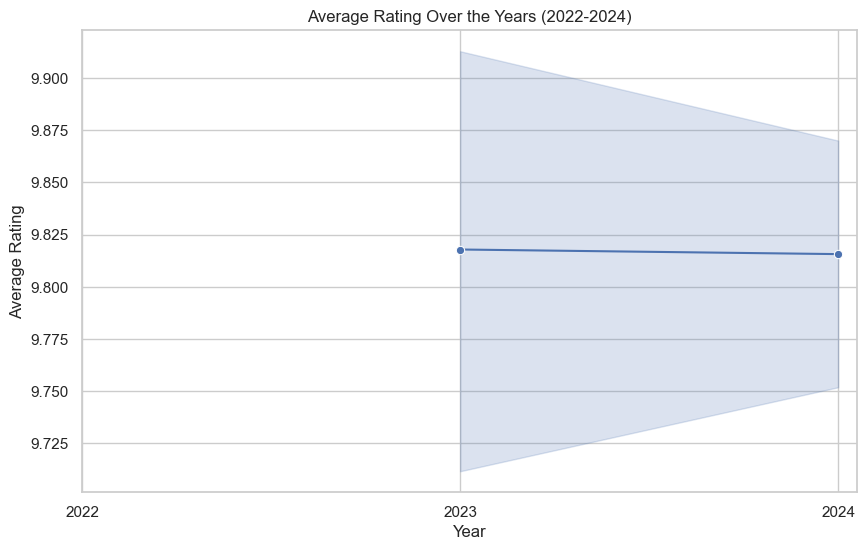

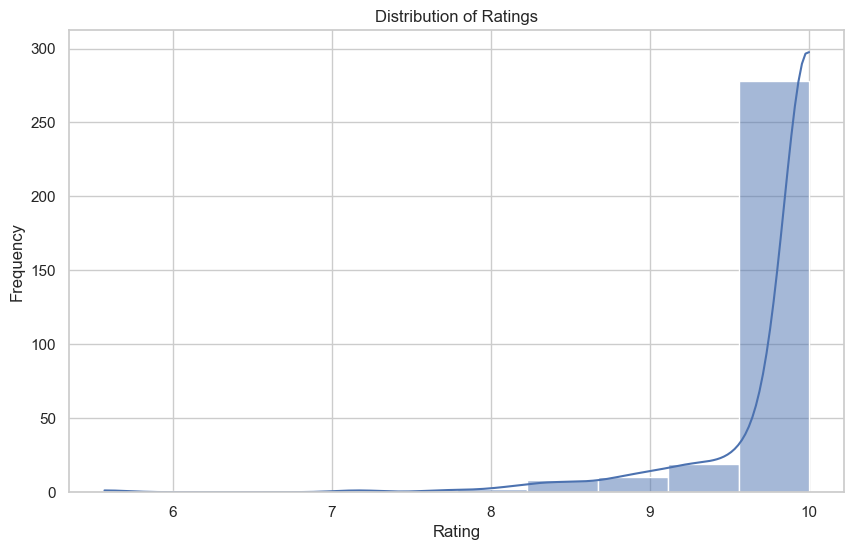

/var/folders/fp/hhn7s8v11t38d1j_yr3spp940000gn/T/ipykernel_51243/267682882.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=response_count.index, y=response_count.values, palette='viridis')


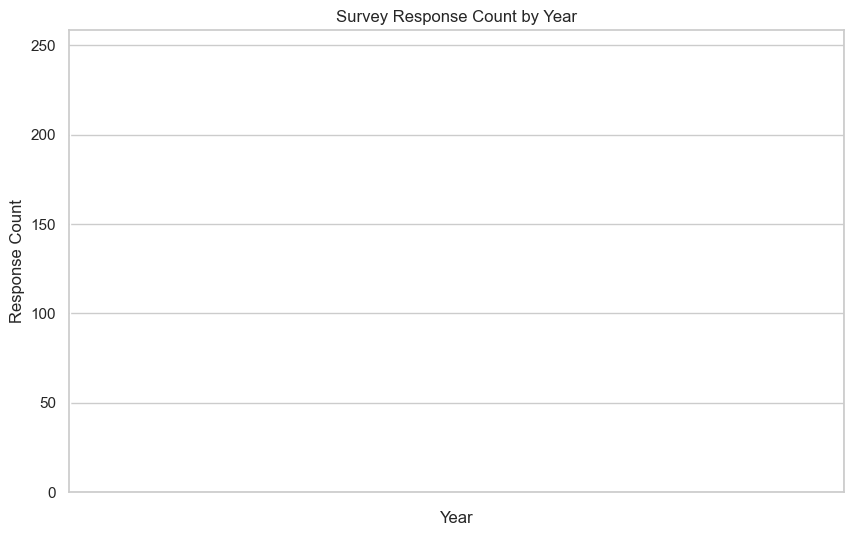

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the survey data from the CSV file
data = pd.read_csv("courtice_survey_data_2022_2024.csv")

# Set the visualisation style
sns.set(style="whitegrid")

# 1. Average Rating Over the Years
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='year', y='avgRating', estimator='mean', marker='o')
plt.title('Average Rating Over the Years (2022-2024)')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.xticks([2022, 2023, 2024])  # Adjust the x-ticks as needed
plt.grid(True)
plt.savefig('avg_rating_over_years.png')  # Save the plot as a PNG file
plt.show()

# 2. Distribution of Ratings
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='rating', bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('distribution_of_ratings.png')  # Save the plot as a PNG file
plt.show()

# 3. Survey Response Count by Year
response_count = data['year'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=response_count.index, y=response_count.values, palette='viridis')
plt.title('Survey Response Count by Year')
plt.xlabel('Year')
plt.ylabel('Response Count')
plt.xticks([2022, 2023, 2024])  # Adjust the x-ticks as needed
plt.grid(True)
plt.savefig('survey_response_count_by_year.png')  # Save the plot as a PNG file
plt.show()

# 4. Average Ratings by Survey Questions (if applicable)
# Note: Adjust the question column names based on your actual data
# Example: If there's a column 'question1_rating', replace it accordingly
questions = ['question1_rating', 'question2_rating', 'question3_rating']  # Replace with your actual question columns

for question in questions:
    if question in data.columns:
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=data, x='year', y=question, estimator='mean', marker='o')
        plt.title(f'Average Rating for {question.replace("_", " ").title()} Over the Years (2022-2024)')
        plt.xlabel('Year')
        plt.ylabel('Average Rating')
        plt.xticks([2022, 2023, 2024])  # Adjust the x-ticks as needed
        plt.grid(True)
        plt.savefig(f'avg_rating_{question}.png')  # Save the plot as a PNG file
        plt.show()
